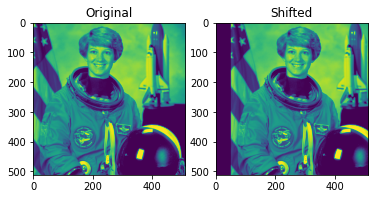

In [7]:
from skimage import data, color
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

astronaut = color.rgb2gray(data.astronaut()) 
shifted = ndi.shift(astronaut, (0, 50))

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(astronaut)
axes[0].set_title('Original')
axes[1].imshow(shifted)
axes[1].set_title('Shifted');

In [8]:
import numpy as np

def mean_squared_error(imageA, imageB):
    return np.mean((imageA - imageB) ** 2)

Text(0, 0.5, 'mean_squared_error')

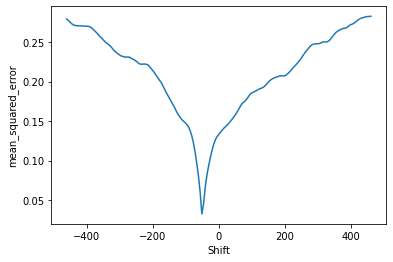

In [17]:
ncol = astronaut.shape[1] # 512
shifts = np.linspace(-0.9 * ncol, 0.9 * ncol, 181) # 
mse_costs = []

for shift in shifts:
 shifted_back = ndi.shift(shifted, (0, shift))
 mse_costs.append(mean_squared_error(astronaut, shifted_back))
fig, ax = plt.subplots()

ax.plot(shifts, mse_costs)
ax.set_xlabel('Shift')
ax.set_ylabel('mean_squared_error')

In [15]:
from scipy import optimize

def astronaut_shift_error(shift, image):
 corrected = ndi.shift(image, (0, shift))
 return mean_squared_error(astronaut, corrected)

res = optimize.minimize(astronaut_shift_error, 0, args=(shifted,),method='Powell')

print(f'The optimal shift for correction is: {res.x}')

The optimal shift for correction is: [-49.99997566]


In [16]:
shifted2 = ndi.shift(astronaut, (0, -340))
res = optimize.minimize(astronaut_shift_error, 0, args=(shifted2,), method='Powell')

print(f'The optimal shift for correction is {res.x}')

The optimal shift for correction is [-38.51778619]


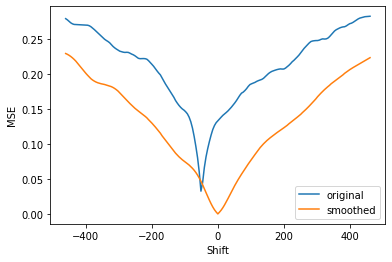

In [18]:
from skimage import filters

astronaut_smooth = filters.gaussian(astronaut, sigma=20)

mse_costs_smooth = []
shifts = np.linspace(-0.9 * ncol, 0.9 * ncol, 181)
for shift in shifts:
    shifted3 = ndi.shift(astronaut_smooth, (0, shift))
    mse_costs_smooth.append(mean_squared_error(astronaut_smooth, shifted3))

fig, ax = plt.subplots()
ax.plot(shifts, mse_costs, label='original')
ax.plot(shifts, mse_costs_smooth, label='smoothed')
ax.legend(loc='lower right')
ax.set_xlabel('Shift')
ax.set_ylabel('MSE');

In [19]:
def downsample2x(image):
    offsets = [((s + 1) % 2) / 2 for s in image.shape]
    slices = [slice(offset, end, 2)
              for offset, end in zip(offsets, image.shape)]
    coords = np.mgrid[slices]
    return ndi.map_coordinates(image, coords, order=1)


def gaussian_pyramid(image, levels=6):
    pyramid = [image]

    for level in range(levels - 1):
        blurred = ndi.gaussian_filter(image, sigma=2/3)
        image = downsample2x(image)
        pyramid.append(image)

    return reversed(pyramid)

Text(0, 0.5, 'MSE')

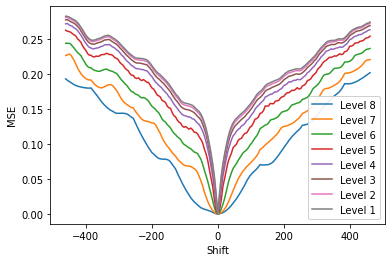

In [21]:
shifts = np.linspace(-0.9 * ncol, 0.9 * ncol, 181)
nlevels = 8
costs = np.empty((nlevels, len(shifts)), dtype=float)
astronaut_pyramid = list(gaussian_pyramid(astronaut, levels=nlevels))
for col, shift in enumerate(shifts):
 shifted = ndi.shift(astronaut, (0, shift))
 shifted_pyramid = gaussian_pyramid(shifted, levels=nlevels)
 for row, image in enumerate(shifted_pyramid):
     costs[row, col] = mean_squared_error(astronaut_pyramid[row], image)

fig, ax = plt.subplots()
for level, cost in enumerate(costs):
 ax.plot(shifts, cost, label='Level %d' % (nlevels - level))
 
ax.legend(loc='lower right', frameon=True, framealpha=0.9)
ax.set_xlabel('Shift')
ax.set_ylabel('MSE')

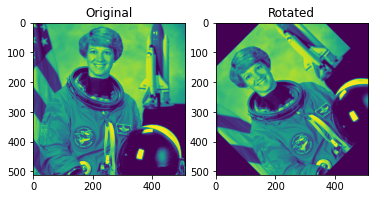

In [22]:
from skimage import transform

def make_rigid_transform(param):
    r, tc, tr = param
    return transform.SimilarityTransform(rotation=r,
                                         translation=(tc, tr))

rotated = transform.rotate(astronaut, 45)

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(astronaut)
axes[0].set_title('Original')
axes[1].imshow(rotated)
axes[1].set_title('Rotated');

In [24]:
def cost_mse(param, reference_image, target_image):
    transformation = make_rigid_transform(param)
    transformed = transform.warp(target_image, transformation, order=3)
    return mean_squared_error(reference_image, transformed)

In [31]:
def align(reference, target, cost=cost_mse):
    nlevels = 7
    pyramid_ref = gaussian_pyramid(reference, levels=nlevels)
    pyramid_tgt = gaussian_pyramid(target, levels=nlevels)

    levels = range(nlevels, 0, -1)
    image_pairs = zip(pyramid_ref, pyramid_tgt)
    p = np.zeros(3)

    for n, (ref, tgt) in zip(levels, image_pairs):
        p[1:] *= 2

        res = optimize.minimize(cost, p, args=(ref, tgt), method='Powell')
        p = res.x

        # print current level, overwriting each time (like a progress bar)
        print(f'Level: {n}, Angle: {np.rad2deg(res.x[0]) :.3}, '
              f'Offset: ({res.x[1] * 2**n :.3}, {res.x[2] * 2**n :.3}), '
              f'Cost: {res.fun :.3}', end='\r')

    print('')  # newline when alignment complete
    return make_rigid_transform(p)

Level: 1, Angle: -60.0, Offset: (-1.87e+02, 6.98e+02), Cost: 0.0369


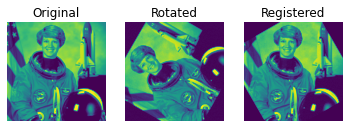

In [32]:
from skimage import util

theta = 60
rotated = transform.rotate(astronaut, theta)
rotated = util.random_noise(rotated, mode='gaussian',
                            seed=0, mean=0, var=1e-3)

tf = align(astronaut, rotated)
corrected = transform.warp(rotated, tf, order=3)

f, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.imshow(astronaut)
ax0.set_title('Original')
ax1.imshow(rotated)
ax1.set_title('Rotated')
ax2.imshow(corrected)
ax2.set_title('Registered')
for ax in (ax0, ax1, ax2):
    ax.axis('off')

Level: 1, Angle: -50.0, Offset: (-2.09e+02, 5.74e+02), Cost: 0.0385


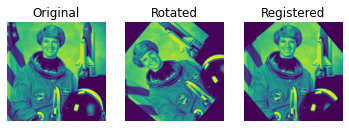

In [29]:
theta = 50
rotated = transform.rotate(astronaut, theta)
rotated = util.random_noise(rotated, mode='gaussian',
                            seed=0, mean=0, var=1e-3)

tf = align(astronaut, rotated)
corrected = transform.warp(rotated, tf, order=3)

f, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.imshow(astronaut)
ax0.set_title('Original')
ax1.imshow(rotated)
ax1.set_title('Rotated')
ax2.imshow(corrected)
ax2.set_title('Registered')
for ax in (ax0, ax1, ax2):
    ax.axis('off')